In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm, trange

In [2]:
import matplotlib.font_manager as font_manager
# Specify the path to your personal fonts directory
font_dirs = ['/home/jiayinhao/.fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

# Add the fonts to the font manager
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Create a FontProperties object for 'Times New Roman'
font = font_manager.FontProperties(family='Arial',
                                   weight='bold',
                                   style='normal', 
                                   size=11)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
mpl.rcParams['axes.linewidth'] = 2

# Cross-correlation

In [3]:
def build_component_matrix(CM1, column_index, start_offset, end_offset, total_res=1090):
    """
    Builds a component matrix from the specified slices of the given DataFrame loaded from GROMACS gmx covar output.

    Parameters:
    CM1 (pd.DataFrame): The DataFrame of covariance matrix to slice.
    column_index (int): The column index to use from CM1.
    start_offset, end_offset (int): The offsets to calculate the start and end row for each slice.
    total_res (int): The total number of rows for the component matrix.
    iterations (int): The number of iterations/slices to perform.

    Returns:
    pd.DataFrame: The constructed component matrix.
    """
    component_matrix = pd.DataFrame(index=range(total_res), columns=range(total_res))

    for i in trange(total_res):
        start_row = start_offset + 3*total_res * i
        end_row = end_offset + 3*total_res * i
        component_matrix.iloc[:, i] = CM1.iloc[start_row:end_row, column_index].values

    return component_matrix

# Example usage
# xcomp_matrix = build_component_matrix(CM1, 0, 0, 1090)
# ycomp_matrix = build_component_matrix(CM1, 1, 1090, 2180)
# zcomp_matrix = build_component_matrix(CM1, 2, 2180, 3270)


In [4]:
# Make DCCM from covariance matrix
def compute_normalized_covariance_matrix(covariance_matrix):
    """
    Computes the normalized covariance matrix (correlation matrix).

    Parameters:
    covariance_matrix (pd.DataFrame): A pandas DataFrame representing the covariance matrix.

    Returns:
    pd.DataFrame: The normalized covariance matrix.
    """
    # Compute the square roots of the diagonal elements (standard deviations)
    std_devs = np.sqrt(np.diag(covariance_matrix.astype(float)))

    # Create a matrix of these standard deviations
    std_matrix = np.outer(std_devs, std_devs)

    # Element-wise division of the covariance matrix by the standard deviation matrix
    normalized_matrix = covariance_matrix / std_matrix

    # Ensure the result is a DataFrame
    normalized_matrix = pd.DataFrame(normalized_matrix)

    return normalized_matrix

In [5]:
def DCCM_from_GROMACS(original_matrix):
    """
    Use function build_component_matrix() and compute_normalized_covariance_matrix() to build the DCCM matrix
    Input: The orginal DataFrame loaded from GROMACS gmx covar output (e.g. covar.dat)
    """

    xcomp_matrix = build_component_matrix(original_matrix, 0, 0, 1090)
    ycomp_matrix = build_component_matrix(original_matrix, 1, 1090, 2180)
    zcomp_matrix = build_component_matrix(original_matrix, 2, 2180, 3270)

    covariance_matrix = xcomp_matrix.add(ycomp_matrix).add(zcomp_matrix)
    DCCM_Matrix = compute_normalized_covariance_matrix(covariance_matrix)
    DCCM_Matrix = DCCM_Matrix[DCCM_Matrix.columns].astype(float)

    return DCCM_Matrix

In [6]:
def plot_DCCM(data, tick_interval=200, line_positions=None, cmap='bwr_r', xlabel='Residue number', ylabel='Residue number', vmax=None, vmin=None):
    """
    Plots a DCCM matrix heatmap with lines to indicate specific domains.

    Parameters:
    data (pd.DataFrame): The DataFrame to plot.
    tick_interval (int): Interval between tick labels.
    line_positions (list of tuples): List of tuples for line positions (x, y).
    cmap (str): Colormap for the heatmap.
    xlabel, ylabel (str): Labels for the X and Y axes.
    vmax, vmin (float): Max and min values for color scaling.
    
    """
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 12), dpi=250, ncols=2, gridspec_kw={'width_ratios': [20, 0.9]})
    plt.subplots_adjust(wspace=0.04)  # adjust spacing

    # Create heatmap
    sns.heatmap(data, square=True, cmap=cmap, center=0, yticklabels=tick_interval, xticklabels=tick_interval, cbar_ax=ax1, ax=ax0, vmax=vmax, vmin=vmin)
    ax0.invert_yaxis()

    # Set ticks and labels
    tick_positions = list(range(0, data.shape[0], tick_interval))
    ax0.set_xticks(tick_positions)
    ax0.set_xticklabels(tick_positions, fontsize=32, rotation=0)
    ax0.set_yticks(tick_positions)
    ax0.set_yticklabels(tick_positions, fontsize=32, rotation=90)
    ax0.set_xlabel(xlabel, fontsize=36)
    ax0.set_ylabel(ylabel, fontsize=36)
    ax0.tick_params(direction="in")
    ax1.tick_params(direction="in")
    ax1.yaxis.set_tick_params(labelsize=16)

    # Set spines
    for spine in ax0.spines.values():
        spine.set_visible(True)
    for spine in ax1.spines.values():
        spine.set_visible(True)

    # Add lines if positions are provided
    if line_positions:
        for x, y in line_positions:
            ax0.axhline(y=y, color='black', linewidth=1.5)
            ax0.axvline(x=x, color='black', linewidth=1.5)

    plt.show()

# Example usage
# line_positions = [(78, 78), (207, 207), (383, 383), (538, 538), (819, 819), (870, 870)]
# plot_heatmap(DCCM_test_WT_1, line_positions=line_positions)


In [7]:
# mutation point
mutation_mpoint = [(159,159),(207,207),(523,523),(867,867)]

In [8]:
# reference: AlphaFold
col_names = ['cl1_x','cl2_y','cl3_z']
WT300K_1us = pd.read_csv('..//BrCas12b/simulation/rep_final/PCA_Ca_1us/Alpha/BrCas12b_WT300K_1us_covar.dat',delim_whitespace=True, names=col_names)

In [9]:
DCCM_WT300K_1us = DCCM_from_GROMACS(WT300K_1us)

100%|██████████| 1090/1090 [00:00<00:00, 4442.88it/s]


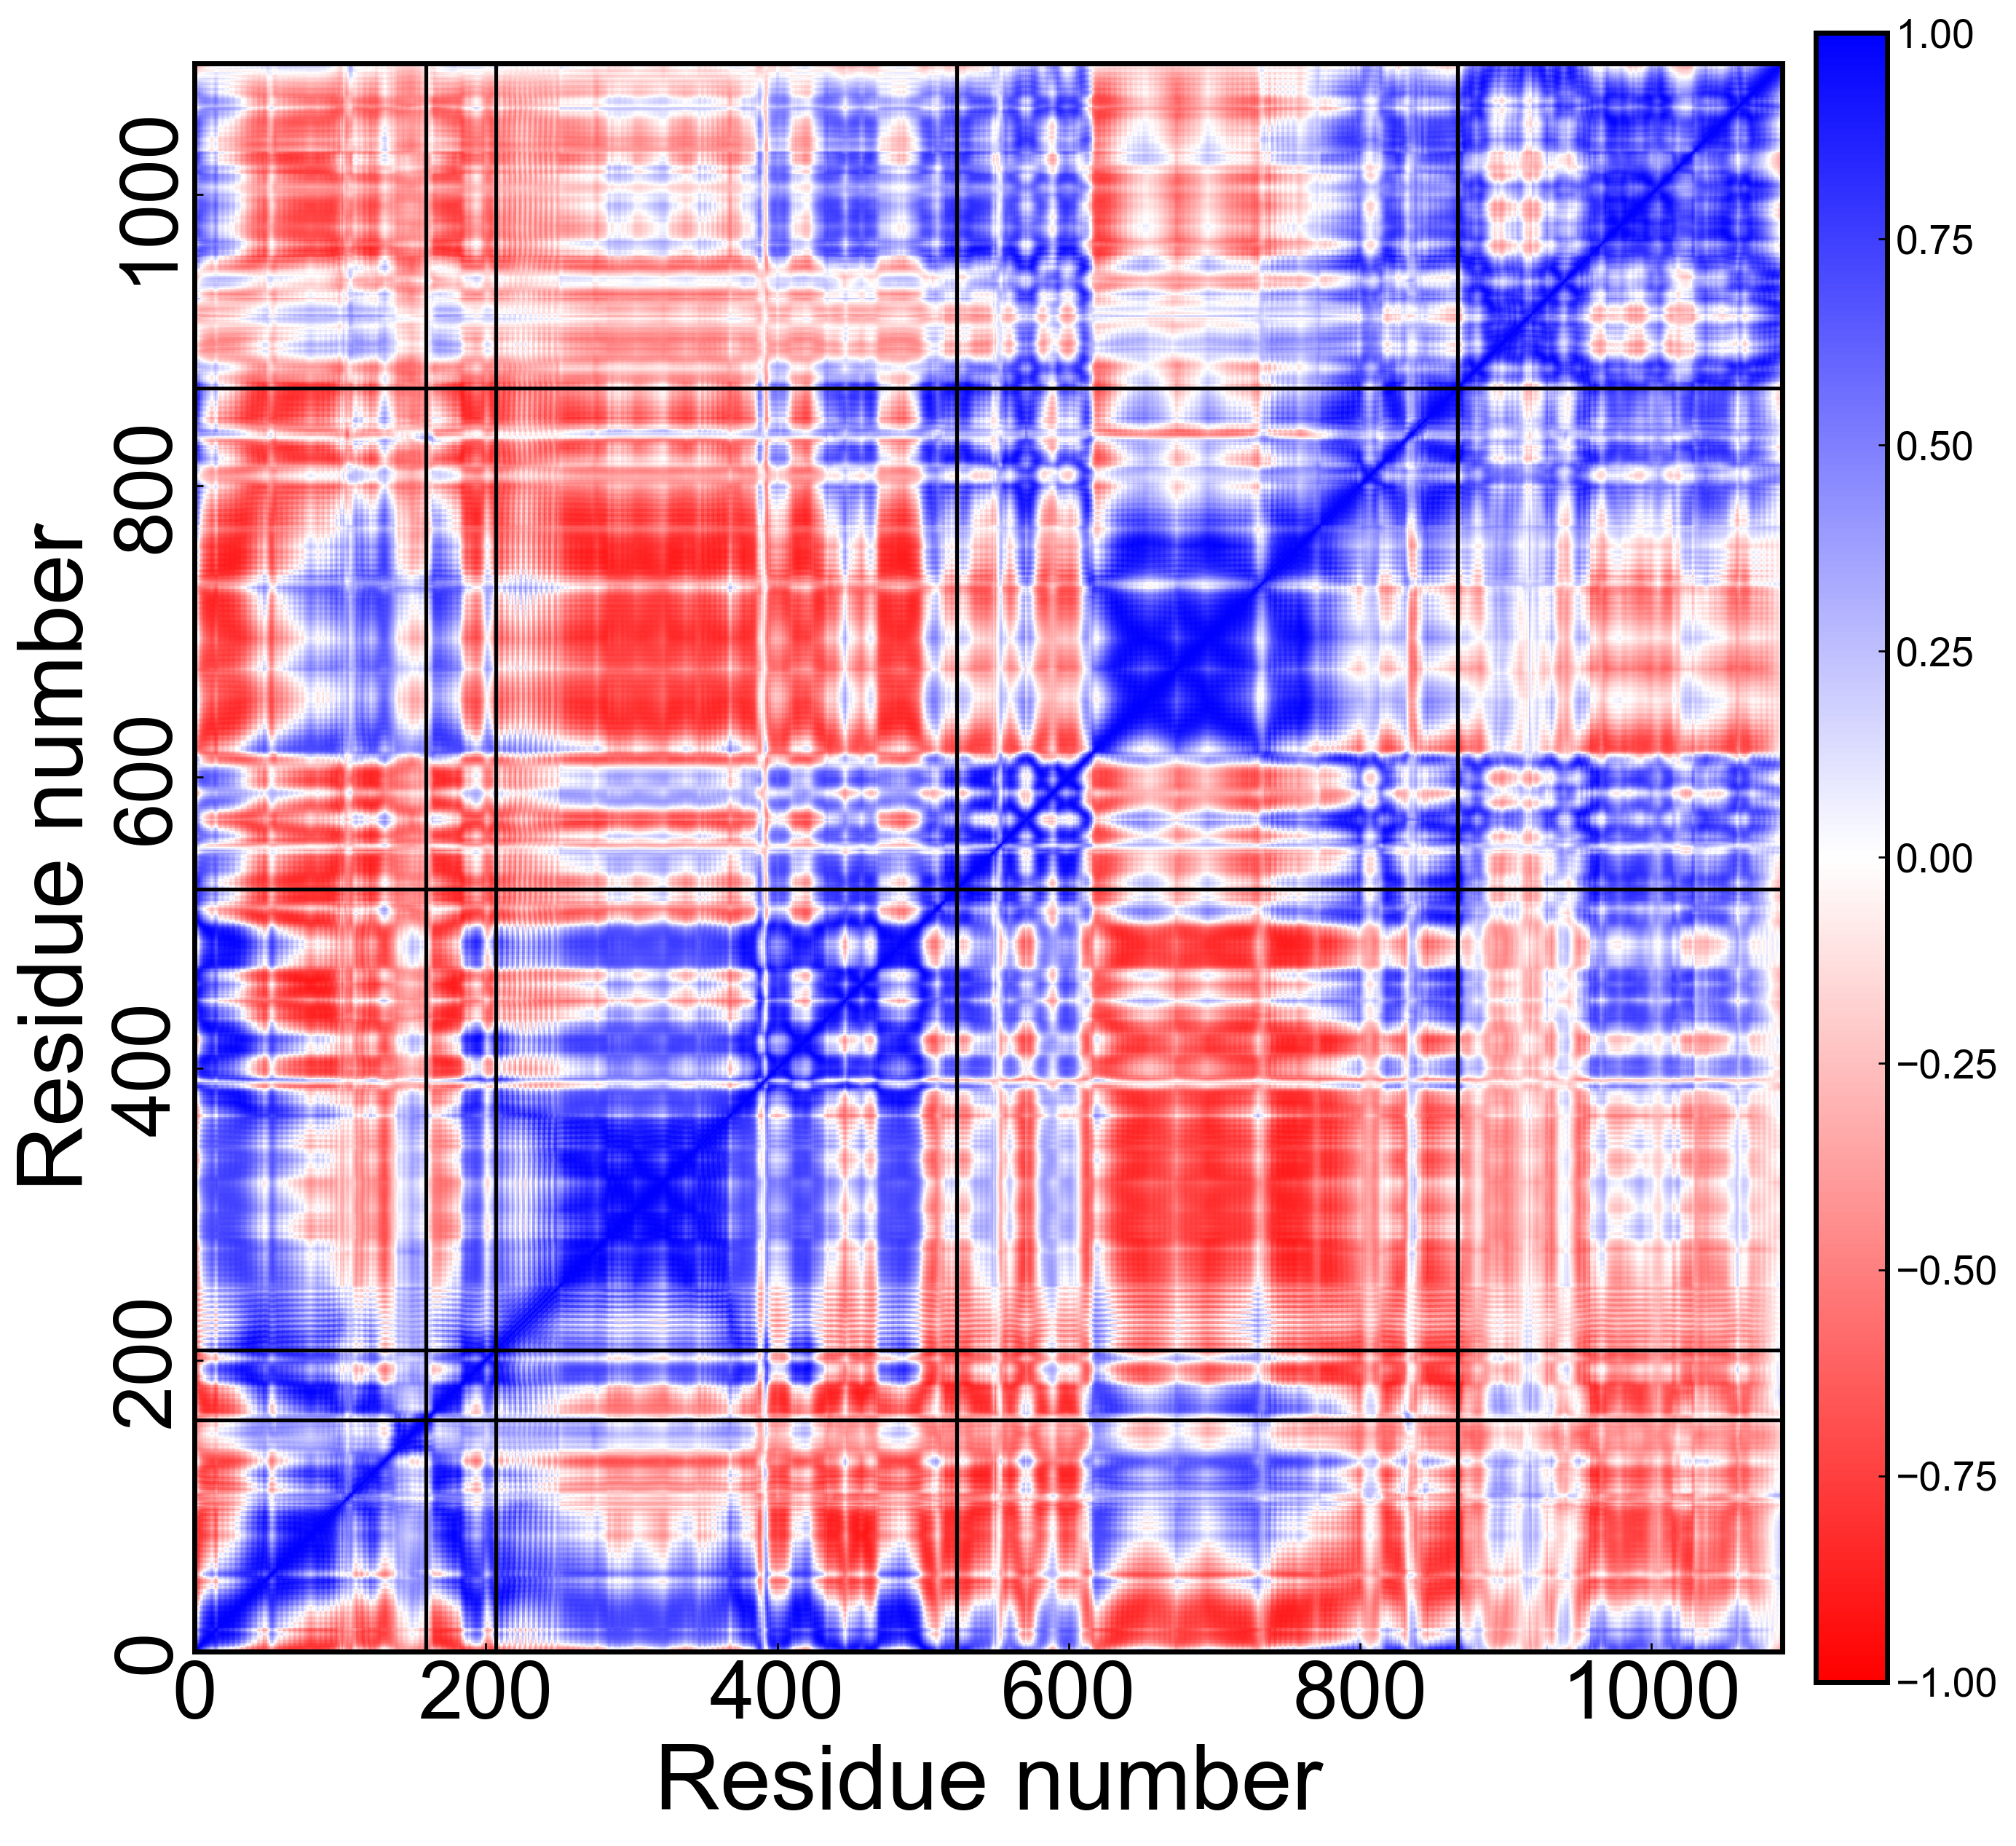

In [10]:
plot_DCCM(DCCM_WT300K_1us, line_positions=mutation_mpoint,vmax=1, vmin=-1)

# correlation score

In [11]:
# define domain info
domain_index_list = [(0,22), (22,78), (78,208), (208,384), (384,539), (539,622), (622,659), (659,819), (819,871), (871,951), (951,966), (966,1090)]
Domain_list = ['OBD-I','REC1-I','PI','REC1-II','OBD-II','RuvC-I','BH','REC2','RuvC-II','UK-I','RuvC-III','UK-II']

In [12]:
# generate matrix used for normalization
Csi_matrix_multi = pd.DataFrame()

for Domain_index_1 in range(0,12):
    start1, end1 = domain_index_list[Domain_index_1]
    list1_test = []
    for Domain_index_2 in range(0,12):
        start2, end2 = domain_index_list[Domain_index_2]
        temp = (end1 - start1 - 1)*(end2 - start2 -1)
        list1_test.append(temp)
    Csi_matrix_multi = pd.concat([Csi_matrix_multi, pd.DataFrame([list1_test])], ignore_index=True)
# Add column name
Csi_matrix_multi.columns = Domain_list 

In [13]:
# Domain correlation score calculation:
def calculate_csi_matrix(domain_index_list, dccm_matrix, col_range):
    """
    Convert from DCCM into domain Correlation Score
    Parameter:
    domain_index_list: list of protein domains
    dccm_matrix: DCC matrix
    col_range: usually the same as domain_index_list
    """
    csi_rows = []
    for domain_index in tqdm(domain_index_list):
        start, end = domain_index
        Csi_inter_temp = 0 
        for i in range(start, end):
            for j in range(col_range[0],col_range[1]):
                Csi_inter_temp += dccm_matrix.iloc[i,j]
        csi_rows.append(Csi_inter_temp)
    return pd.DataFrame(csi_rows)


In [14]:
def plot_Csi_domain_12domain(Csi_matrix_n, figsize=(12, 11), dpi=250, cmap='bwr_r', center=0, vmax=None, vmin=None):
    fig, (ax0, ax1) = plt.subplots(figsize=figsize, dpi=dpi, ncols=2, gridspec_kw={'width_ratios': [20, 0.9]})
    plt.subplots_adjust(wspace=0.04)  # adjust spacing

    # Create heatmap
    sns.heatmap(Csi_matrix_n, square=True, cmap=cmap, center=center, cbar_ax=ax1, ax=ax0, vmax=vmax, vmin=vmin)
    ax0.invert_yaxis()

    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=32, rotation=90)
    ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=32, rotation=0) # , weight='bold'
    ax0.set_xlabel('', fontsize=36)
    ax0.set_ylabel('', fontsize=36)
    ax0.tick_params(direction="in")
    ax1.tick_params(direction="in")
    ax1.yaxis.set_tick_params(labelsize=18)

    # Set spines
    for spine in ax0.spines.values():
        spine.set_visible(True)
    for spine in ax1.spines.values():
        spine.set_visible(True)

    plt.show()

In [15]:
# perform calculation
Csi_matrix_WT300_1us = pd.DataFrame()
Csi_matrix_WT300_1us = pd.concat([calculate_csi_matrix(domain_index_list, DCCM_WT300K_1us, col_range) for col_range in domain_index_list], axis=1)
# Add column name
Csi_matrix_WT300_1us.columns = Domain_list 

100%|██████████| 12/12 [00:02<00:00,  5.30it/s]


In [16]:
# Normalization
Csi_matrix_WT300_1us_n = Csi_matrix_WT300_1us/Csi_matrix_multi
Csi_matrix_WT300_1us_n=Csi_matrix_WT300_1us_n.set_axis(Domain_list ,axis=0) 
np.fill_diagonal(Csi_matrix_WT300_1us_n.values, 1)

Csi_matrix_WT300_1us_n=Csi_matrix_WT300_1us_n.set_axis(Domain_list ,axis=0)
Csi_matrix_WT300_1us_n=Csi_matrix_WT300_1us_n.set_axis(Domain_list ,axis=1)

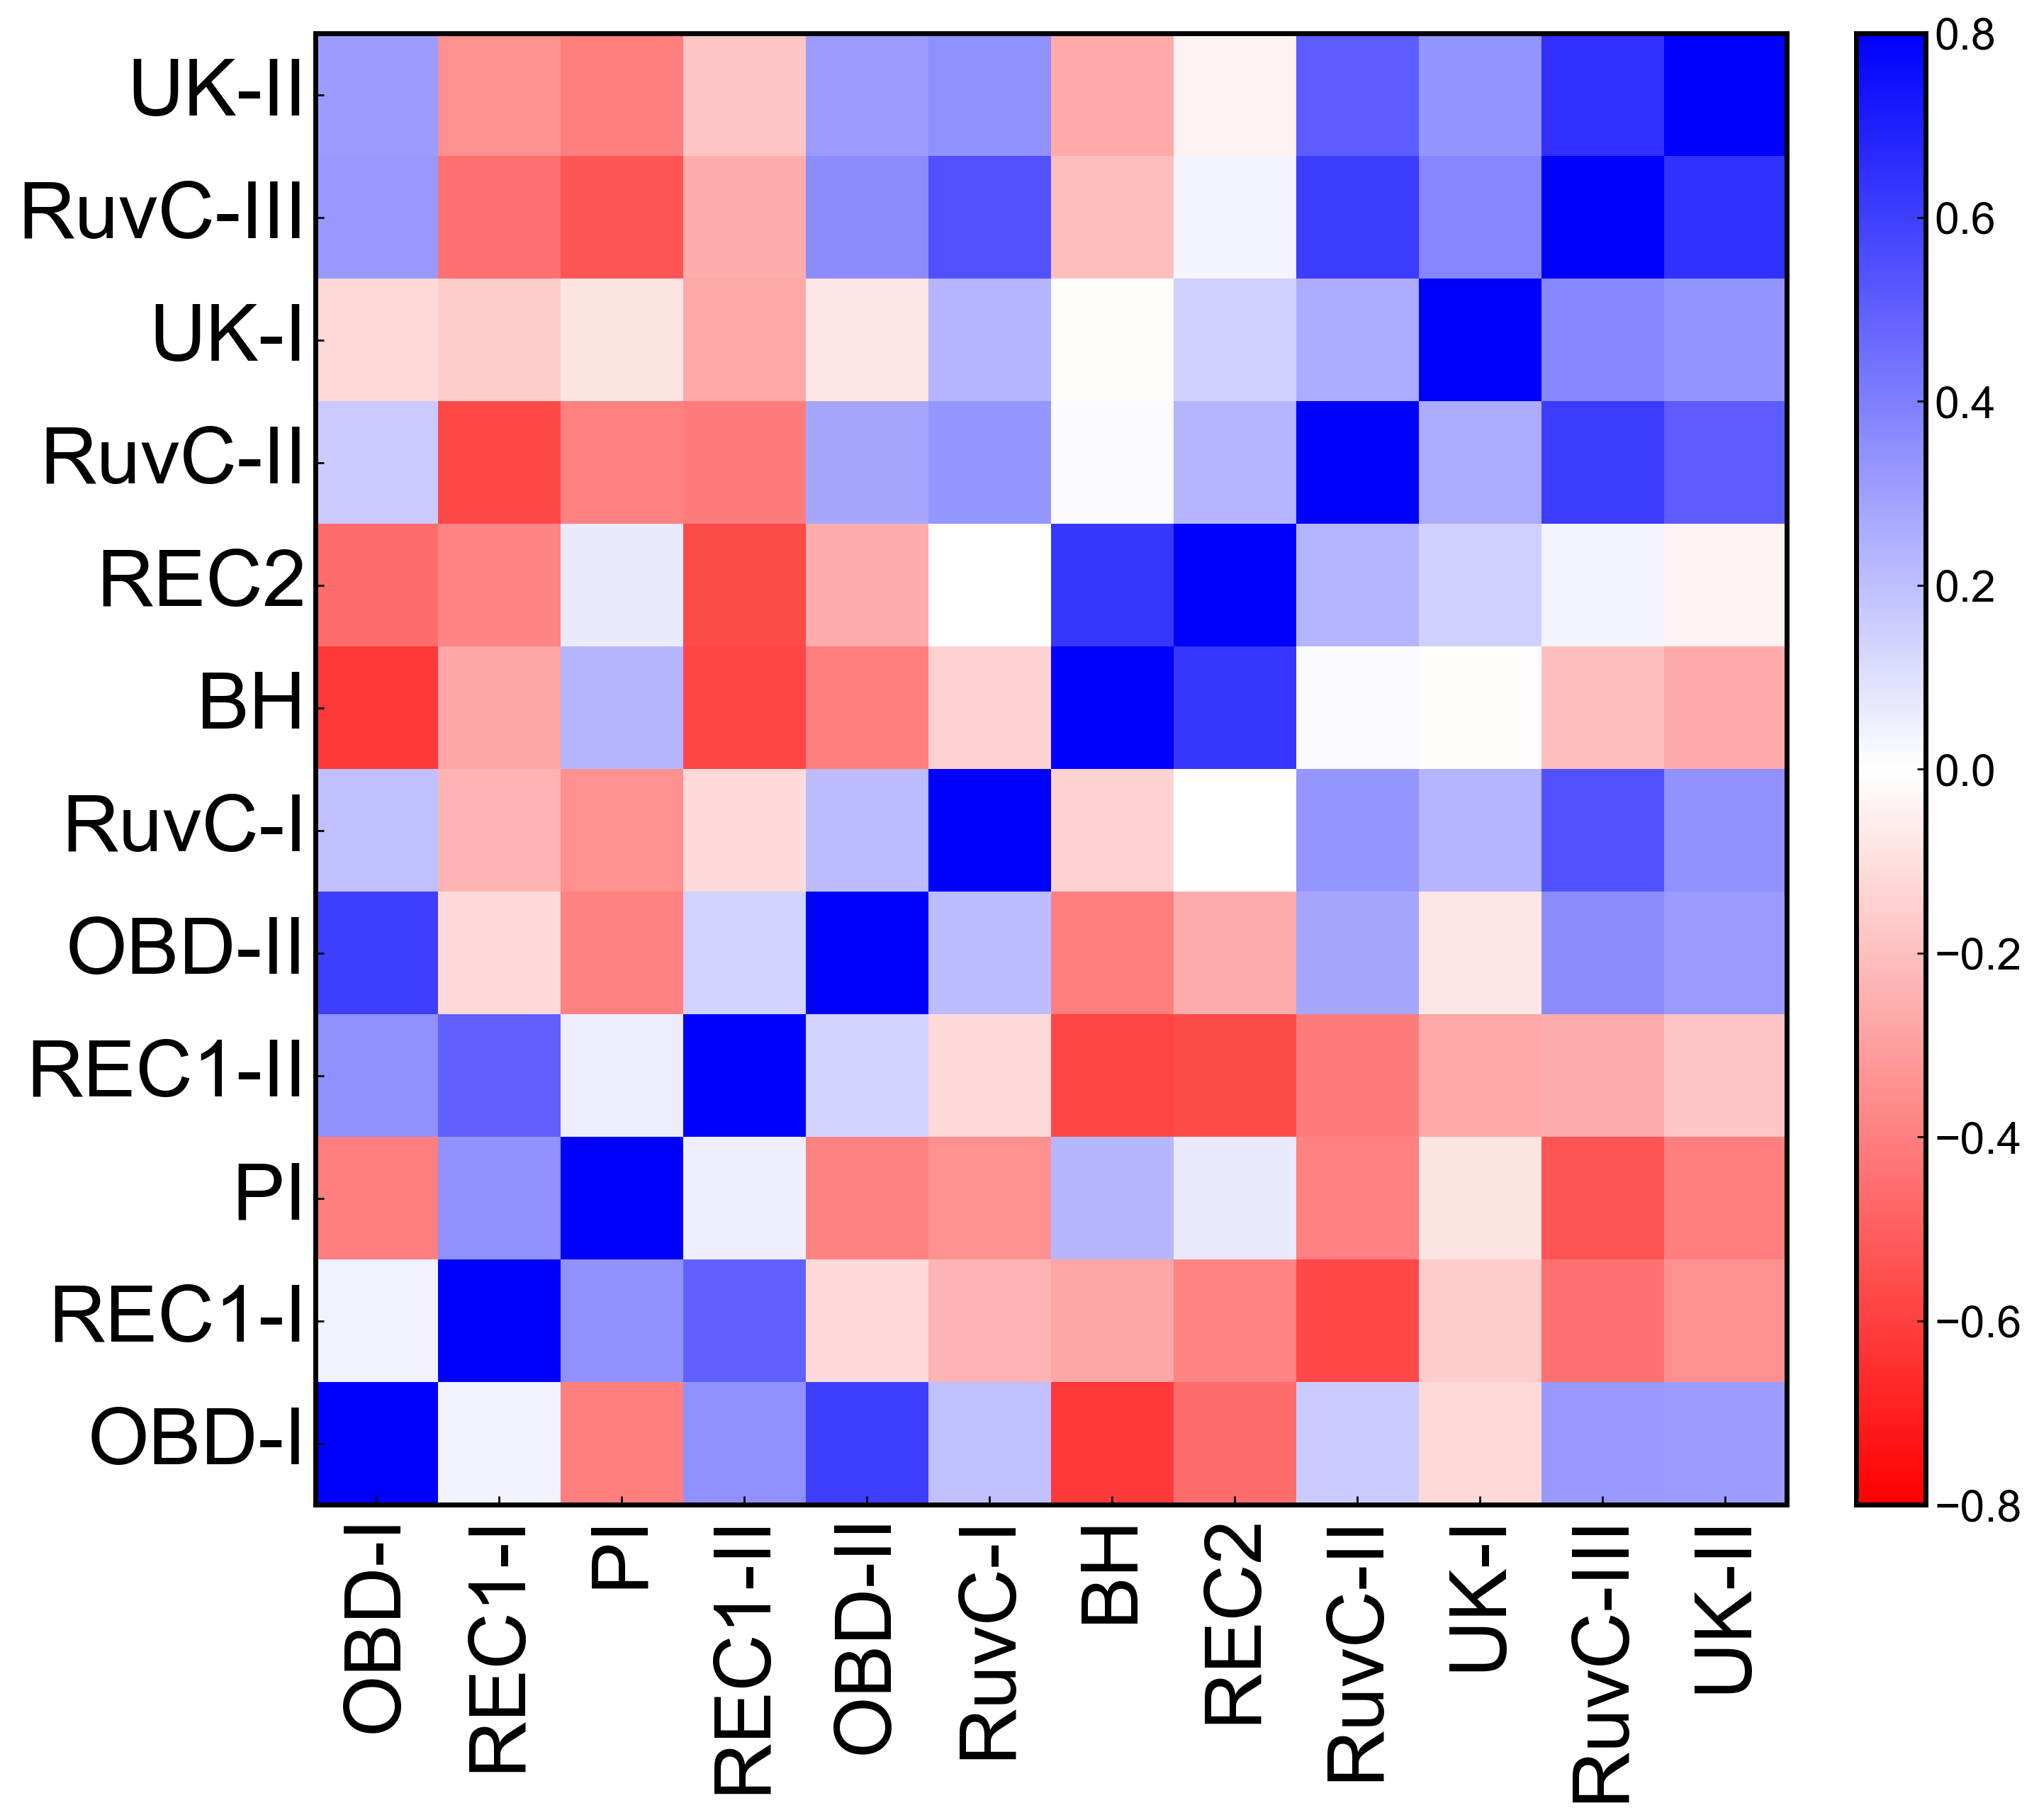

In [17]:
plot_Csi_domain_12domain(Csi_matrix_WT300_1us_n,vmax=0.8,vmin=-0.8)